In [1]:
# Install jax_cosmo with cache disabling mechanism
!pip install --quiet git+https://github.com/ASKabalan/jax_cosmo &> /dev/null

# Ray Tracing with JaxPM

This notebook demonstrates how to perform ray tracing simulations using `JaxPM` to generate weak lensing convergence maps. It covers the full pipeline from setting up initial conditions, running an
N-body simulation, extracting density planes, and finally computing and visualizing the convergence maps.

**Key Concepts:**
-   **Cosmology Setup:** Defining the cosmological model using `jax_cosmo`.
-   **Initial Conditions:** Generating initial density fields and particle displacements using Linear Perturbation Theory (LPT).
-   **N-body Simulation:** Evolving the particle distribution over time using a symplectic ODE solver.
-   **Density Plane Extraction:** Slicing the 3D particle distribution into 2D density planes at various redshifts.
-   **Weak Lensing Convergence:** Computing the convergence ($\kappa$) maps from the density planes using the Born approximation.
-   **Visualization:** Plotting density planes and convergence maps.

In [4]:
import os
os.environ["JC_CACHE"] = "off"
os.environ["JAX_PLATFORM_NAME"] = "cpu"

from functools import partial
from typing import Any, NamedTuple

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import jax_cosmo.constants as constants
from diffrax import ODETerm, RecursiveCheckpointAdjoint, SaveAt, diffeqsolve , SemiImplicitEuler , ConstantStepSize
from jax.scipy.ndimage import map_coordinates
from jax_cosmo.scipy.integrate import simps
from jaxpm.distributed import fft3d, ifft3d, normal_field, uniform_particles
from jaxpm.kernels import fftk
from jaxpm.painting import cic_paint_2d , cic_paint_dx
from jaxpm.pm import growth_factor, growth_rate, pm_forces , linear_field  ,lpt , make_diffrax_ode
from jaxpm.growth import E
from jaxpm.utils import gaussian_smoothing
from jaxpm.ode import symplectic_ode
from jaxpm.lensing import density_plane_fn , convergence_Born , spherical_density_fn , spherical_convergence_Born
import matplotlib.pyplot as plt


In [5]:
jax.config.update("jax_enable_x64", False)

# Flat Sky Projection

   ## 1. Setup and Cosmology
   
   First, we import necessary libraries and define our cosmological model. We use `jax_cosmo` for cosmological calculations and `diffrax` for solving the N-body ODE.

In [6]:
Planck18 = partial(
    jc.Cosmology,
    # Omega_m = 0.3111
    Omega_c=0.2607,
    Omega_b=0.0490,
    Omega_k=0.0,
    h=0.6766,
    n_s=0.9665,
    sigma8=0.8102,
    w0=-1.0,
    wa=0.0,
)

fiducial_cosmo = Planck18()

## 2. Simulation Parameters
  
Here, we define the key parameters for our N-body simulation and ray tracing. These include the mesh shape, box size, and properties related to the density planes and lensing fields.


In [7]:
mesh_shape = [256, 256, 256]
box_size = [800.0, 800.0, 800.0]
density_plane_width = 100.
density_plane_npix = 256
density_plane_smoothing=0.1
field_size = 9.6
field_npix = 256
min_redshift = 0.0

## Redshift Distribution of Sources

We define and visualize the redshift distribution of source galaxies. This distribution is crucial for weighting the contribution of different density planes to the final convergence map.

/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


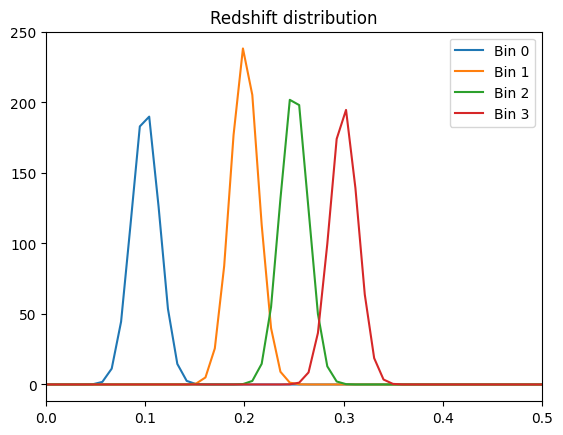

In [6]:
from scipy.stats import norm

max_comoving_distance = box_size[2]  # in Mpc/h
max_redshift = (1 / jc.background.a_of_chi(fiducial_cosmo, max_comoving_distance / fiducial_cosmo.h) - 1).squeeze()
z = jnp.linspace(0, max_redshift, 1000)

nz_shear = [
    jc.redshift.kde_nz(
        z, norm.pdf(z, loc=z_center, scale=0.01), bw=0.01, zmax=max_redshift, gals_per_arcmin2=g
    )
    for z_center, g in zip([0.1, 0.2, 0.25, 0.3], [7, 8.5, 7.5, 7])
]
nbins = len(nz_shear)


# Plotting the redshift distribution
z = jnp.linspace(0, 1.2, 128)

for i in range(nbins):
    plt.plot(
        z,
        nz_shear[i](z) * nz_shear[i].gals_per_arcmin2,
        color=f"C{i}",
        label=f"Bin {i}",
    )
plt.legend()
plt.xlim(0, 0.5)
plt.title("Redshift distribution")
plt.show()


## 4. Running the N-body Simulation

This section sets up and runs the N-body simulation.
-   We generate initial conditions based on a linear matter power spectrum.
-   Particles are displaced using LPT.
-   The simulation is evolved using a symplectic ODE solver from `diffrax`.
-   During the simulation, density planes are extracted at specific scale factors (redshifts) using the `density_plane_fn`.



In [7]:
t0 = 0.1  # Initial scale factor
t1 = 1.0  # Final scale factor
dt0 = 0.05  # Initial time step

@jax.jit
def run_simulation(cosmo):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmo, k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles=None,a=0.1,order=1)
    
    # Evolve the simulation forward
    drift , kick = symplectic_ode(mesh_shape, paint_absolute_pos=False)
    ode_fn = ODETerm(kick), ODETerm(drift)
    solver = SemiImplicitEuler()


    a_init = t0
    n_lens = int(box_size[-1] // density_plane_width)
    r = jnp.linspace(0.0, box_size[-1], n_lens + 1)
    r_center = 0.5 * (r[1:] + r[:-1])
    a_center = jc.background.a_of_chi(cosmo, r_center)
    saveat = SaveAt(ts=a_center[::-1], fn=density_plane_fn(mesh_shape, box_size, density_plane_width, density_plane_npix, None))

    stepsize_controller = ConstantStepSize()
    res = diffeqsolve(ode_fn,
                      solver,
                      t0=t0,
                      t1=t1,
                      dt0=dt0,
                      y0=(p , dx),
                      args=cosmo,
                      saveat=saveat,
                      stepsize_controller=stepsize_controller)

    density_planes = res.ys
    return initial_conditions ,  dx , density_planes , res.stats

initial_conditions , lpt_displacements , density_planes , solver_stats = run_simulation(fiducial_cosmo)

## 5. Visualizing Density Planes

After running the simulation, we can visualize the extracted 2D density planes. Each plane represents the matter distribution at a specific redshift slice.


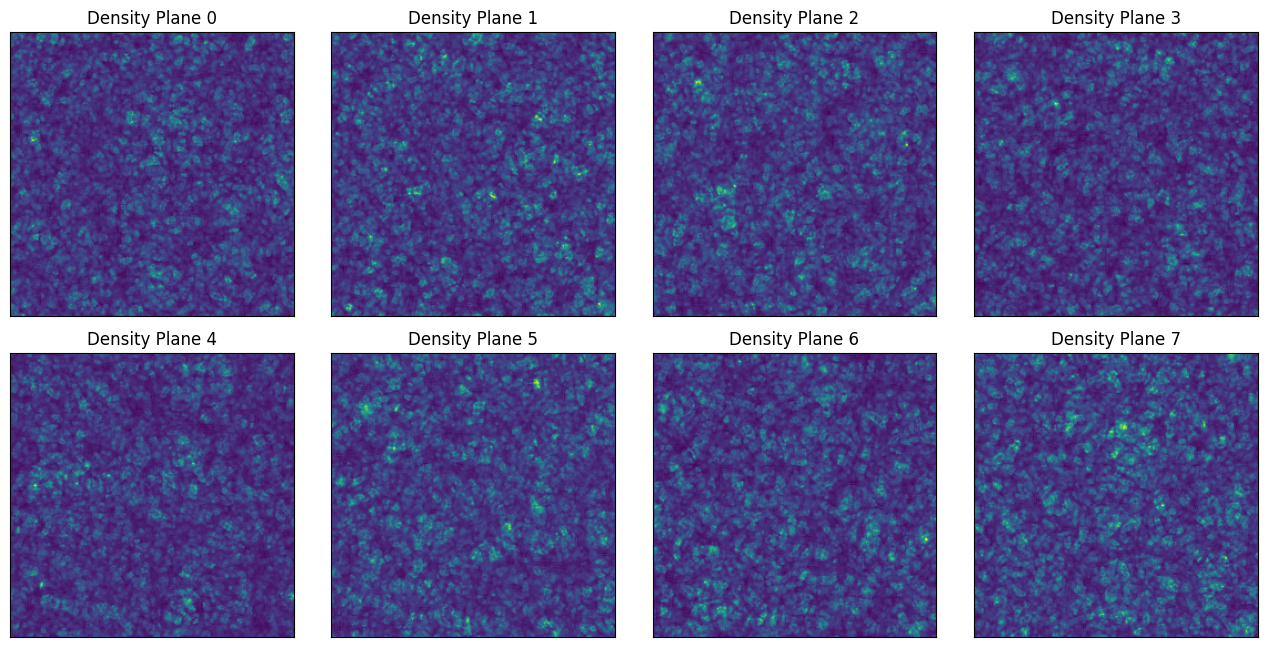

In [8]:
fig = plt.figure(figsize=(13, 13))

for i , density_plane in enumerate(density_planes):
    plt.subplot(4, 4, i + 1)
    plt.imshow(density_plane, origin="lower", cmap="viridis", extent=[0, box_size[0], 0, box_size[1]])
    plt.title(f"Density Plane {i}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

 ## 6. Computing Weak Lensing Convergence Maps
   
  Finally, we compute the weak lensing convergence maps.
  -   The `compute_convergence` function takes the extracted density planes and integrates them along the line of sight, weighted by the source redshift distribution, to produce convergence maps.
  -   The Born approximation is used for this calculation.
  -   The resulting maps are then visualized.



In [9]:
def compute_convergence(density_planes, cosmo, field_size, field_npix, min_redshift=0.0 , max_redshift=2.0):
    dx = box_size[0] / density_plane_npix
    dz = density_plane_width

    n_lens = int(box_size[-1] // density_plane_width)
    r = jnp.linspace(0.0, box_size[-1], n_lens + 1)
    r_center = 0.5 * (r[1:] + r[:-1])
    a_center = jc.background.a_of_chi(cosmo, r_center)

    #lightcone = jax.vmap(lambda x: gaussian_smoothing(x, density_plane_smoothing / dx))(
    #    density_planes
    #)
    lightcone = density_planes

    lightcone = lightcone[::-1]
    lightcone = jnp.transpose(lightcone, axes=(1, 2, 0))
    # Defining the coordinate grid for lensing map
    xgrid, ygrid = jnp.meshgrid(
        jnp.linspace(0, field_size, mesh_shape[0], endpoint=False),  # range of X coordinates
        jnp.linspace(0, field_size, mesh_shape[1], endpoint=False),
    )  # range of Y coordinates

    coords = jnp.array((jnp.stack([xgrid, ygrid], axis=0)) * (jnp.pi / 180))  # deg->rad

    convergence_maps = [
                simps(
                    lambda z: nz(z).reshape([-1, 1, 1])
                    * convergence_Born(fiducial_cosmo, lightcone, r_center, a_center, dx, dz, coords, z),
                    min_redshift,
                    max_redshift,
                    N=32,
                )
                for nz in nz_shear
            ]

    # Reshape the maps to desired resoluton
    convergence_maps = [
        kmap.reshape(
            [
                field_npix,
                mesh_shape[0] // field_npix,
                field_npix,
                mesh_shape[1] // field_npix,
            ]
        )
        .mean(axis=1)
        .mean(axis=-1)
        for kmap in convergence_maps
    ]
    return convergence_maps


kappas = compute_convergence(density_planes, fiducial_cosmo, field_size, field_npix)

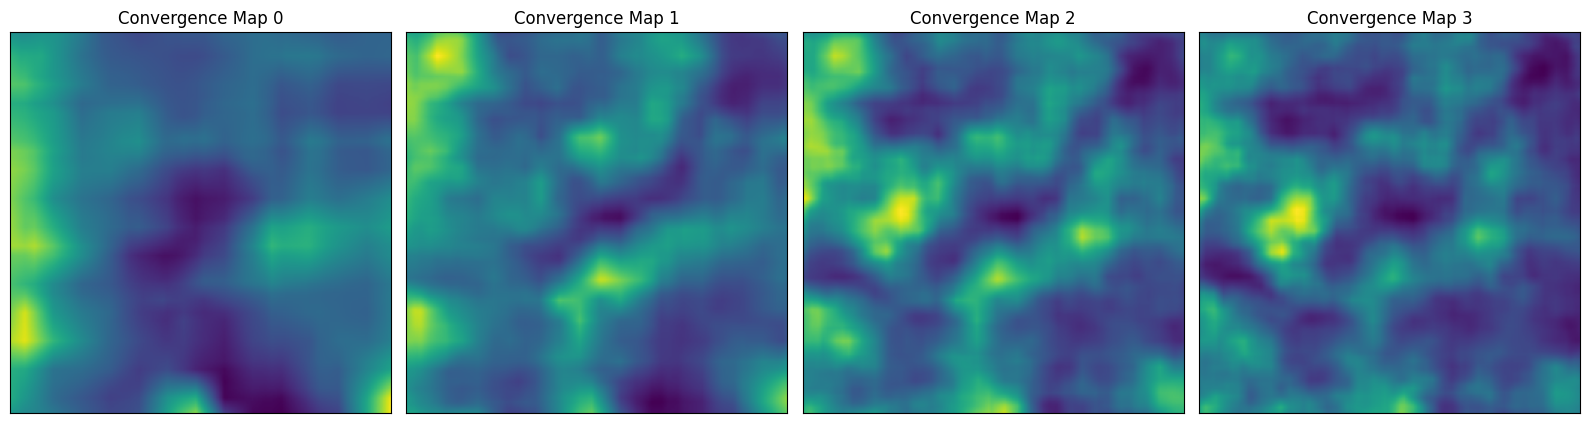

In [10]:
fig = plt.figure(figsize=(16, 16))
for i, kappa in enumerate(kappas):
    plt.subplot(1, 4, i + 1)
    plt.imshow(kappa, origin="lower", cmap="viridis", extent=[0, field_size, 0, field_size])
    plt.title(f"Convergence Map {i}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()